In [1]:
#import các thư viện
import pandas as pd
import numpy as np
%matplotlib inline 
#to plot the whatever graphic
import matplotlib.pyplot as plt #plot data
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [2]:
#import data BID
df_BID = pd.read_csv('../BID-Historical-Data.csv')
df_BID = df_BID[['Date','Price']]
df_BID

,Date,Price
0,1/2/2019,"25,639.00"
1,1/3/2019,"24,491.00"
2,1/4/2019,"24,146.60"
3,1/7/2019,"24,720.60"
4,1/8/2019,"24,491.00"
...,...,...
1096,5/26/2023,"43,400.00"
1097,5/29/2023,"43,900.00"
1098,5/30/2023,"43,800.00"
1099,5/31/2023,"44,000.00"


In [3]:
#import data VNI
df_VNI=pd.read_csv('../VN Index Historical Data.csv')
df_VNI= df_VNI[['Date','Price']]
df_VNI

,Date,Price
0,1/2/2019,891.75
1,1/3/2019,878.22
2,1/4/2019,880.9
3,1/7/2019,889.64
4,1/8/2019,887.44
...,...,...
1096,5/26/2023,"1,063.76"
1097,5/29/2023,"1,074.98"
1098,5/30/2023,"1,078.05"
1099,5/31/2023,"1,075.17"


In [4]:
#Chuyển dữ liệu lần cuối, % thay đổi về dạng int
df_BID['Price']=df_BID['Price'].replace(',','',regex=True).astype(float)
df_VNI['Price']=df_VNI['Price'].replace(',','',regex=True).astype(float)

In [5]:
df = pd.merge(df_BID, df_VNI, on='Date')
df.head()

,Date,Price_x,Price_y
0,1/2/2019,25639.0,891.75
1,1/3/2019,24491.0,878.22
2,1/4/2019,24146.6,880.90
3,1/7/2019,24720.6,889.64
4,1/8/2019,24491.0,887.44


In [6]:
name_mapping = {'Price_x':'Price_BID','Price_y':'Price_VNI'}

In [7]:
df = df.rename(columns=name_mapping)
df

,Date,Price_BID,Price_VNI
0,1/2/2019,25639.0,891.75
1,1/3/2019,24491.0,878.22
2,1/4/2019,24146.6,880.90
3,1/7/2019,24720.6,889.64
4,1/8/2019,24491.0,887.44
...,...,...,...
1096,5/26/2023,43400.0,1063.76
1097,5/29/2023,43900.0,1074.98
1098,5/30/2023,43800.0,1078.05
1099,5/31/2023,44000.0,1075.17


In [8]:
# data = data.reset_index(drop=True) # Reset the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Price_BID', 'Price_VNI']]
df = df.dropna() # Drop missing values

# Split the df into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
print(len(train_data))
print(len(test_data))
print(len(val_data))

660
330
111


In [9]:
train_exog = train_data[["Price_VNI"]]
model = auto_arima(train_data['Price_BID'], 
                      test='adf',       # use adftest to find      
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,  
                      stepwise=True,
                      exogenous= train_exog)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10495.948, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10488.138, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10490.055, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10490.052, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10486.234, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10492.011, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.296 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  660
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5242.117
Date:                Sat, 03 Jun 2023   AIC                          10486.234
Time:                        00:12:36   BIC                          10490.725
Sample:                             0   HQIC                         10487.975
    

In [10]:
model= SARIMAX(train_data['Price_BID'], 
 exog=train_exog,
 order=(2,1,2),
 enforce_invertibility=False, enforce_stationarity=False)

c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price_BID'])
test_exog = test_data[['Price_VNI']]
model_fit = model.fit()
# y_pred = model.predict(n_periods=len(y_test))
y_pred = model_fit.forecast(steps=len(y_test), exog=test_exog)
print(y_pred)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price_BID'])
val_exog = val_data[['Price_VNI']]
print(val_exog)
y_pred_val =  model_fit.forecast(steps=len(y_val), exog=val_exog)
print(y_pred_val)

c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


660    31111.163293
661    31502.735323
662    31120.629200
663    31630.408455
664    32272.645949
           ...     
985    20898.692890
986    20086.822873
987    20719.374082
988    20841.936020
989    21043.052757
Name: predicted_mean, Length: 330, dtype: float64
            Price_VNI
Date                 
2022-12-16    1052.48
2022-12-19    1038.40
2022-12-20    1023.13
2022-12-21    1018.88
2022-12-22    1022.61
...               ...
2023-05-26    1063.76
2023-05-29    1074.98
2023-05-30    1078.05
2023-05-31    1075.17
2023-06-01    1078.39

[111 rows x 1 columns]
660    20982.940877
661    20350.832828
662    19687.410043
663    19525.566330
664    19706.757072
           ...     
766    21390.174486
767    21851.632521
768    21977.895994
769    21859.446872
770    21991.879570
Name: predicted_mean, Length: 111, dtype: float64


c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Validation RMSE: 23144.69
Testing RMSE: 8406.57
Validation MAPE: 52.24%
Testing MAPE: 18.62%
Validation MAE: 23062.78
Testing MAE: 6817.42


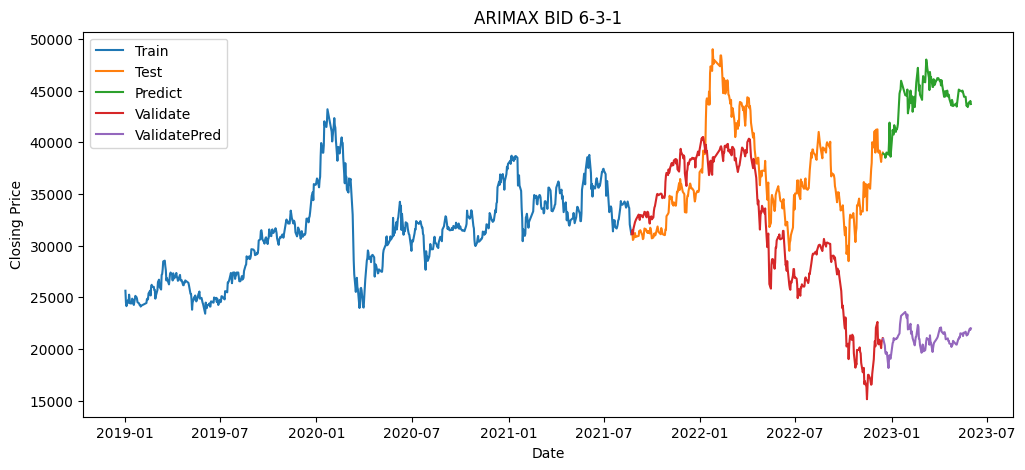

In [12]:
# 8. Tính độ đo
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
valid_mae = mean_absolute_error(y_pred_val,y_val) # MAE
test_mae = mean_absolute_error(y_pred,y_test)
print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Validation MAPE: {valid_mape* 100:.2f}%")
print(f"Testing MAPE: {test_mape*100:.2f}%")
print(f"Validation MAE: {valid_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")

# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Closing Price');
plt.xlabel('Date');
plt.title('ARIMAX BID 6-3-1')
plt.plot(train_data.index, train_data['Price_BID'])
plt.plot(test_data.index, test_data['Price_BID'])
plt.plot(val_data.index, val_data['Price_BID'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
#plt.plot(next_30_days_index,y_next_30_days)
#plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.legend(['Train', 'Test', 'Predict','Validate','ValidatePred'])
plt.show()